In [27]:
from pymongo import MongoClient
import pprint

import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import requests
from bs4 import BeautifulSoup

import json
import time
import copy

import os

from time import sleep
from selenium import webdriver

import sys
import random
import scipy.stats as scs
import numpy as np

In [ ]:
# # instantiating variables to be columns in dataframe
# written_review = ""
# ratings = []
# dates = []
# types = []
# review_text = []
# reviewer_links = []

In [52]:
hike_url = 'https://www.alltrails.com/trail/us/new-york/bald-mountain-loop'

# ChromeDriver & MongoClient
driver = webdriver.Chrome()
client = MongoClient()

driver.get(hike_url)
sleep(3)

driver.execute_script("window.scrollTo(0, 10000)")

# find 'show more reviews button'
search = driver.find_element_by_css_selector("#reviews > div.styles-module__container___px-t2.xlate-none > button")

# prevents error being thrown once total trail reviews is reached; 
showing_results = driver.find_element_by_css_selector('#reviews > div.styles-module__container___px-t2.xlate-none > div')
total_ = int(showing_results.text.split(' ')[-1])
per_page = int(showing_results.text.split(' ')[-3])

# clicks through to see additional reviews
# x = 0
for _ in range(total_//30):
#     if x < 15:
    search.click()
    sleep(1)
#     x += 1
#     else:
#         break

# get page html
html = driver.page_source
time.sleep(2)

# add html to mongo
db = client.bearmountain
trail_name = "".join(((" ".join(((hike_url.split('/'))[-1]).split('-'))).title()).split(" "))
pages = db[trail_name]
pages.insert_one({'link': hike_url, 'html': html})

In [ ]:
# parsing data
soup = BeautifulSoup(html, 'html.parser')

# getting trail title, description, difficulty, info
soup.find('h1', class_='xlate-none styles-module__name___1nEtW').text.rstrip()
soup.find('p', id="auto-overview").text.rstrip()
soup.find('span', class_="styles-module__diff___22Qtv styles-module__moderate___3w1it styles-module__selected___3fawg").text.rstrip()
soup.find('span', class_="styles-module__detailData___kQ-eK").text.rstrip()

# getting reviewer data for trail, appending to lists
for i, review in enumerate(soup.find_all('div', itemprop="review")):

    ratings.append(soup.find_all('span', class_="MuiRating-root default-module__rating___1k45X MuiRating-sizeLarge MuiRating-readOnly")[i]['aria-label'])
    dates.append(soup.find_all('span', class_="styles-module__dateTrailDetails___3qgZC xlate-none")[i].text.rstrip())
    types.append(soup.find_all('span', class_="styles-module__tag___2s-oD styles-module__activityTag___3-RdN")[i].text.rstrip())

    written_review = soup.find_all('div', class_="styles-module__container___3etfA")[i].find('p', itemprop="reviewBody")

    if written_review == None:
        review_text.append(None)

    else:
        review_text.append(soup.find_all('div', class_="styles-module__container___3etfA")[i].find('p', itemprop="reviewBody").text.rstrip())        

#         reviewer_links.append('alltrails.com' + soup.find_all('div', class_="styles-module__container___3etfA")[i].find('a', class_="styles-module__link___2i6Za styles-module__recording___3jQX3 xlate-none")['href'])

In [47]:
# Mongo commands:
# client.list_database_names()
# client.drop_database()
client = MongoClient()
db = client.bearmountain
db.list_collection_names()
# db.collection_name or db[collection_name]
# db.drop_collection('a')

['PopolopenTorneLoop',
 'DoodletownBridlePathLoopTrail',
 'DunderbergBaldMountainAndTheTimpLoop',
 'PerkinsMemorialTowerViaAppalachianTrail',
 'TimpTorneTrail']

In [ ]:
# close Selenium ChromeDriver
driver.close()

In [31]:
# collecting data into dataframe
df = pd.DataFrame({'rating': ratings, 'date':dates, 'desc': types, 'reviews': review_text}).sort_values('rating') # to be added: 'links': reviewer_links

In [ ]:
five = df[df['rating'] == '5 Stars']['reviews'].count() # num of written reviews left by five-star reviewers
four = df[df['rating'] == '4 Stars']['reviews'].count() # num of written reviews left by four-star reviewers
num_five = df[df['rating']=='5 Stars']['rating'].count() # num of five-star reviewers
num_four = df[df['rating']=='4 Stars']['rating'].count() # num of four-star reviewers

table = pd.DataFrame({'Written Reviews': [four, five], 'Total Reviewers': [num_four, num_five]}, index = ['4 Stars', '5 Stars']).T
table = table.style.set_properties(**{'text-align': 'center'})
table
# num of written reviews left by five-star reviewers

In [153]:
# data from first collection

,4 Stars,5 Stars
Written Reviews,47,75
Total Reviewers,206,361


### Frequentist Approach

1. Question: Do 4 star and 5 star reviewers leave comments at different rates?

2. H0: Mu4 = Mu5 (4 and 5 star reviewers are equally likely to leave written reviews — P(R | 4) = P(R | 5))

3. Ha: Mu4 != Mu5 (4 and 5 star reviewers leave written reviews at different rates — P(R | 4) != P(R | 5))

4. Test Statistic: 4-Stars: 206 reviews and 5-Stars: 361 reviewers

5. Distribution: Normal

6. Alpha: 0.2

7. Data:

    4 Stars 47/206
    
    5 Stars 75/361

In [443]:
four_stars_distribution = ([0] * (206 - 47)) + ([1] * 47)
five_stars_distribution = (([0] * (361 - 75)) + ([1] * 75))
# four_stars_prob_distribution = []
# five_stars_prob_distribution = []
# for i in four_stars_distribution:
#     four_stars_prob_distribution.append((mean_pop, 1 - mean_pop)[i])
# for i in five_stars_distribution:
#     five_stars_prob_distribution.append((mean_pop, 1 - mean_pop)[i])
print(f'Mean: \n   4 Stars {round(np.mean(four_stars_distribution),3)} \n   5 Stars {round(np.mean(five_stars_distribution),3)}\n')
print(f'Standard Deviation: \n   4 Stars {round(np.std(four_stars_distribution),3)} \n   5 Stars {round(np.std(five_stars_distribution),3)}')

Mean: 
   4 Stars 0.228 
   5 Stars 0.208

Standard Deviation: 
   4 Stars 0.42 
   5 Stars 0.406


In [444]:
# calculate welch test statistic (function in scipt.py)
test_statistic = welch_test_statistic(four_stars_distribution, five_stars_distribution)
test_statistic

0.5634350201704087

In [458]:
# calculate degrees of freedom
df = welch_satterhwaithe_df(four_stars_distribution, five_stars_distribution)

# set up distribution
students = scs.t(df)

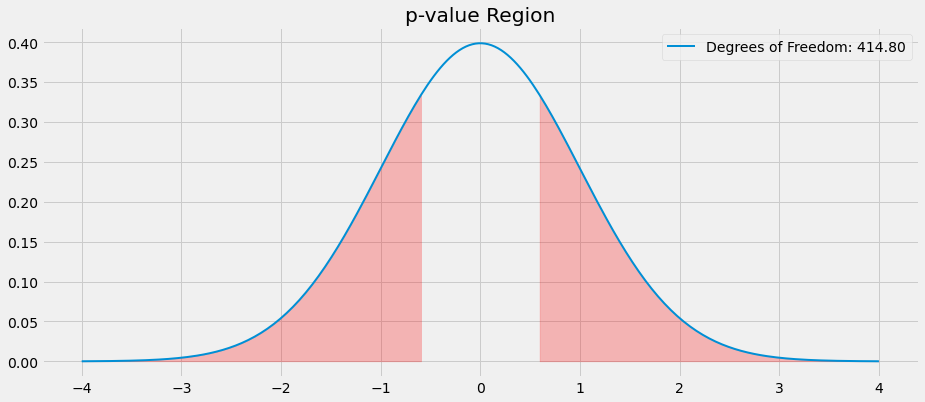

In [459]:
# Plotting distribution of Welch's Test Statistic Assuming H0

x = np.linspace(-4, 4, num=250)
fig, ax = plt.subplots(1, figsize=(14, 6))
students = scs.t(df)
ax.plot(x, students.pdf(x), linewidth=2, label="Degrees of Freedom: {:2.2f}".format(df))
_ = ax.fill_between(x, students.pdf(x), where=(x <= -test_statistic), color="red", alpha=0.25)
_ = ax.fill_between(x, students.pdf(x), where=(x >= test_statistic), color="red", alpha=0.25)
ax.legend()
ax.set_title("p-value Region");

In [447]:
p_value_ = students.cdf(-test_statistic) + (1 - students.cdf(test_statistic))
print("p-value for average written reviews: {:2.2f}".format(p_value_))

p-value for average written reviews: 0.57


8. p-value: 0.57

9. Results: Fail to reject H0.

10. In conclusion, the data fails to show a difference in the average number of written reviews left by 4-star reviewers and 5-star reviewers.